In [0]:
#pip install scikit-learn==0.19.1

In [3]:
!git clone https://github.com/alien8777/Track4

Cloning into 'Track4'...
remote: Enumerating objects: 8177, done.
remote: Total 8177 (delta 0), reused 0 (delta 0), pack-reused 8177
Receiving objects: 100% (8177/8177), 117.03 MiB | 7.59 MiB/s, done.


In [4]:
!ls Track4

driving_log.csv  IMG


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten
import cv2
import pandas as pd 
import random
import os
import ntpath
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.models import load_model
from imgaug import augmenters as iaa

Using TensorFlow backend.


In [6]:
datadir = 'Track4'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


,center,left,right,steering,throttle,reverse,speed
0,C:\Users\lives\Documents\self driving car\Data1\IMG\center_2020_04_15_11_08_30_630.jpg,C:\Users\lives\Documents\self driving car\Data1\IMG\left_2020_04_15_11_08_30_630.jpg,C:\Users\lives\Documents\self driving car\Data1\IMG\right_2020_04_15_11_08_30_630.jpg,0.0,0.0,0,0.000082
1,C:\Users\lives\Documents\self driving car\Data1\IMG\center_2020_04_15_11_08_30_731.jpg,C:\Users\lives\Documents\self driving car\Data1\IMG\left_2020_04_15_11_08_30_731.jpg,C:\Users\lives\Documents\self driving car\Data1\IMG\right_2020_04_15_11_08_30_731.jpg,0.0,0.0,0,0.000079
2,C:\Users\lives\Documents\self driving car\Data1\IMG\center_2020_04_15_11_08_30_837.jpg,C:\Users\lives\Documents\self driving car\Data1\IMG\left_2020_04_15_11_08_30_837.jpg,C:\Users\lives\Documents\self driving car\Data1\IMG\right_2020_04_15_11_08_30_837.jpg,0.0,0.0,0,0.000079
3,C:\Users\lives\Documents\self driving car\Data1\IMG\center_2020_04_15_11_08_30_942.jpg,C:\Users\lives\Documents\self driving car\Data1\IMG\left_2020_04_15_11_08_30_942.jpg,C:\Users\lives\Documents\self driving car\Data1\IMG\right_2020_04_15_11_08_30_942.jpg,0.0,0.0,0,0.000078
4,C:\Users\lives\Documents\self driving car\Data1\IMG\center_2020_04_15_11_08_31_049.jpg,C:\Users\lives\Documents\self driving car\Data1\IMG\left_2020_04_15_11_08_31_049.jpg,C:\Users\lives\Documents\self driving car\Data1\IMG\right_2020_04_15_11_08_31_049.jpg,0.0,0.0,0,0.000078


In [7]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2020_04_15_11_08_30_630.jpg,left_2020_04_15_11_08_30_630.jpg,right_2020_04_15_11_08_30_630.jpg,0.0,0.0,0,0.000082
1,center_2020_04_15_11_08_30_731.jpg,left_2020_04_15_11_08_30_731.jpg,right_2020_04_15_11_08_30_731.jpg,0.0,0.0,0,0.000079
2,center_2020_04_15_11_08_30_837.jpg,left_2020_04_15_11_08_30_837.jpg,right_2020_04_15_11_08_30_837.jpg,0.0,0.0,0,0.000079
3,center_2020_04_15_11_08_30_942.jpg,left_2020_04_15_11_08_30_942.jpg,right_2020_04_15_11_08_30_942.jpg,0.0,0.0,0,0.000078
4,center_2020_04_15_11_08_31_049.jpg,left_2020_04_15_11_08_31_049.jpg,right_2020_04_15_11_08_31_049.jpg,0.0,0.0,0,0.000078


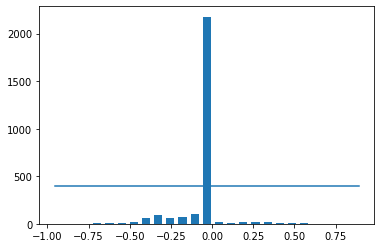

In [8]:
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))


total data: 2740
removed: 1777
remaining: 963


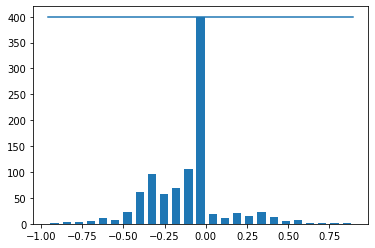

In [9]:
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
 

print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))




In [10]:
print(data.iloc[1])
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
    # left image append
    image_path.append(os.path.join(datadir,left.strip()))
    steering.append(float(indexed_data[3])+0.15)
    # right image append
    image_path.append(os.path.join(datadir,right.strip()))
    steering.append(float(indexed_data[3])-0.15)
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)



center      center_2020_04_15_11_08_31_049.jpg
left        left_2020_04_15_11_08_31_049.jpg  
right       right_2020_04_15_11_08_31_049.jpg 
steering    0                                 
throttle    0                                 
reverse     0                                 
speed       7.76459e-05                       
Name: 4, dtype: object


In [11]:
x_train, x_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(x_train), len(x_valid)))

Training Samples: 2311
Valid Samples: 578


Text(0.5, 1.0, 'Validation set')

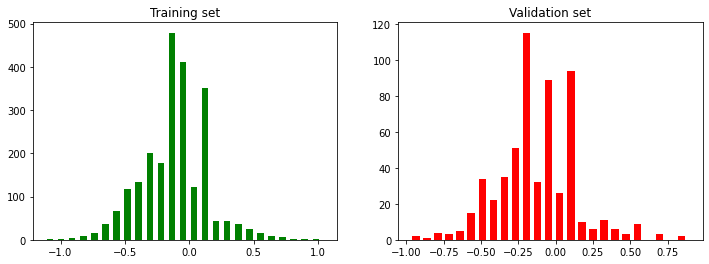

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='green')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')


In [0]:
def zoom(image):
  zoom = iaa.Affine(scale =(1,1.3))
  image = zoom.augment_image(image)
  return image

Text(0.5, 1.0, 'zoomed image')

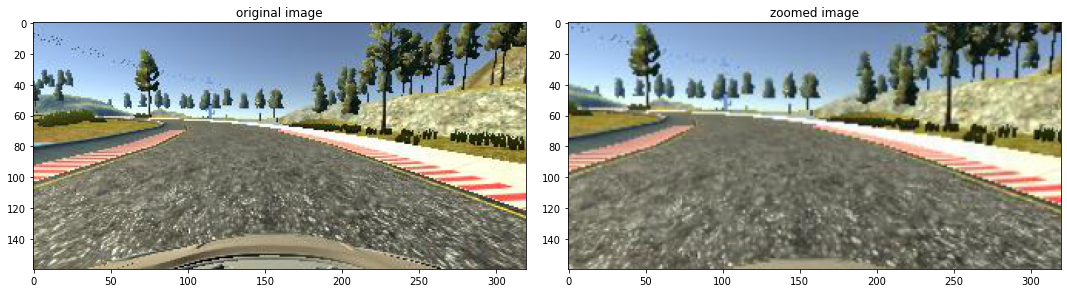

In [14]:
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)


fig, axs = plt.subplots(1,2, figsize = (15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('original image')
axs[1].imshow(zoomed_image)
axs[1].set_title('zoomed image')

In [0]:
def pan(image):
  pan = iaa.Affine(translate_percent = {"x":(-0.1, 0.1), "y":(-0.1,0.1)})
  image = pan.augment_image(image)
  return image 

Text(0.5, 1.0, 'panned image')

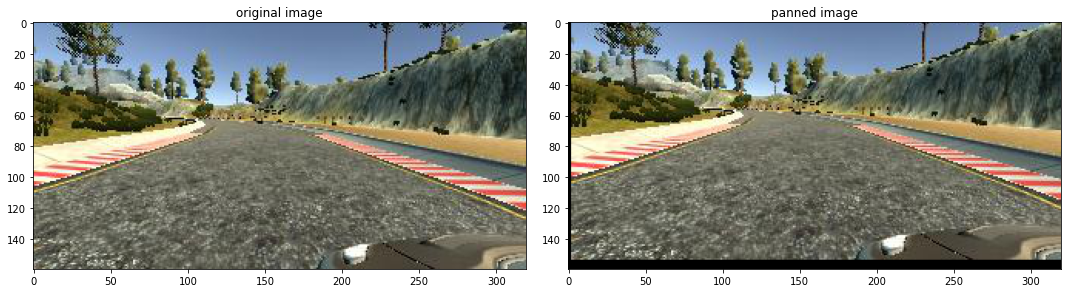

In [16]:
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)


fig, axs = plt.subplots(1,2, figsize = (15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('original image')
axs[1].imshow(panned_image)
axs[1].set_title('panned image')

In [0]:
def img_random_brightness(image):
  brightness = iaa.Multiply((0.2, 1.2)) #multiplies all the pixel intensities inside the image , thus any pixel intensity multiplied by a value less the 1 willl become more darker
  image = brightness.augment_image(image)
  return image 

Text(0.5, 1.0, 'brightness_altered_image')

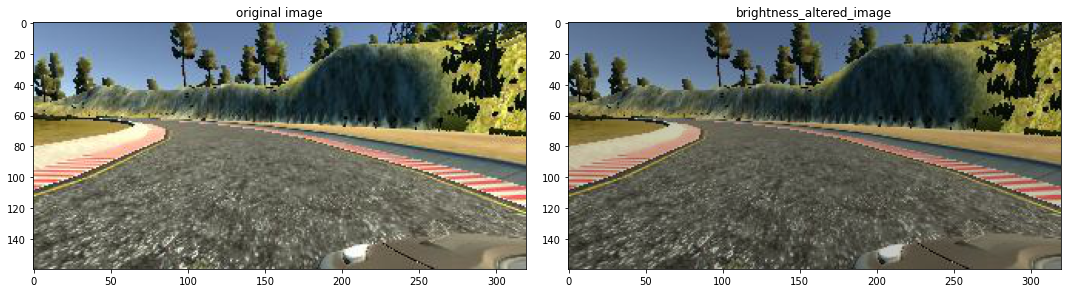

In [18]:
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)


fig, axs = plt.subplots(1,2, figsize = (15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('original image')
axs[1].imshow(brightness_altered_image)
axs[1].set_title('brightness_altered_image')

In [0]:
def img_random_flip(image, steering_angle):
  image = cv2.flip(image, 1)
  steering_angle = -steering_angle
  return image, steering_angle


Text(0.5, 1.0, 'Flipped Image')

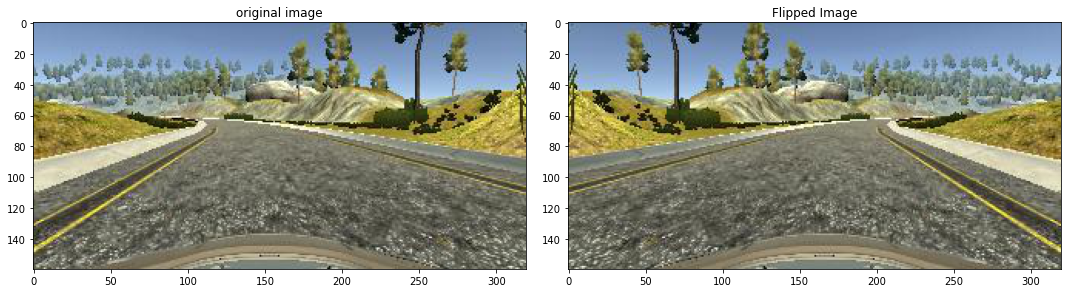

In [20]:
random_index = random.randint(0,1000)
image = image_paths[random_index]
steering_angle = steerings[random_index] 


original_image = mpimg.imread(image)
flipped_image, flipped_streeing_angle = img_random_flip(original_image, steering_angle)


fig, axs = plt.subplots(1,2, figsize = (15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('original image')
axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image')

In [0]:
def random_augment(image, steering_angle):
  image = mpimg.imread(image)
  if np.random.rand() < 0.5:
    image = pan(image)
  if np.random.rand() < 0.5:
    image = zoom(image)
  if np.random.rand() < 0.5:
    image = img_random_brightness(image)
  if np.random.rand() < 0.5:
    image, steering_angle = img_random_flip(image, steering_angle)
  return image, steering_angle 

In [22]:
ncol = 2
nrow = 10
fig, axs = plt.subplots(nrow, ncol, figsize =  (15,50))
fig.tight_layout()
for i in range (10):
  randnum =  random.randint(0, len(image_paths)-1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]

  original_image  = mpimg.imread(random_image)
  augmented_image, steering  = random_augment(random_image, random_steering)
  axs[i][0].imshow(original_image)
  axs[i][0].set_title('Original Image')

  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title('Augmented Image')

Output hidden; open in https://colab.research.google.com to view.

In [0]:
def img_preprocess(img):
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img

Text(0.5, 1.0, 'preprocessed Image')

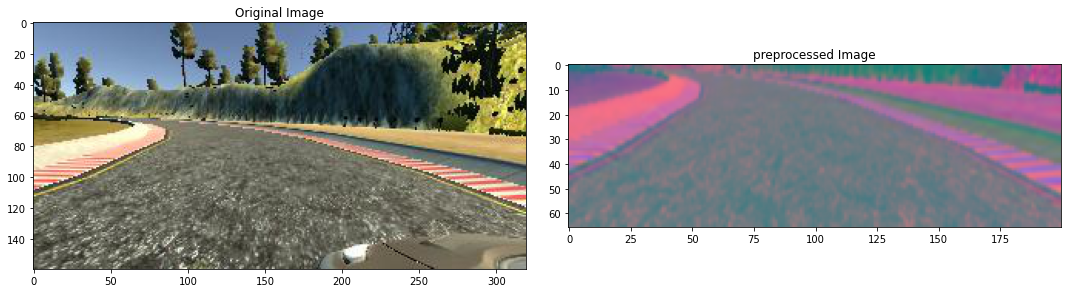

In [24]:
image = image_paths[10]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)

fig, axs = plt.subplots(1,2 ,figsize = (15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('preprocessed Image')

In [0]:
def batch_generator(image_paths, steering_angle, batch_size, istraining):
  while True:
    batch_img = []
    batch_steering = []
    for i in range (batch_size):
      random_index = random.randint(0, len(image_paths)-1)
      if istraining:
        img ,steering = random_augment(image_paths[random_index], steering_angle[random_index])
      else:
        img = mpimg.imread(image_paths[random_index])
        steering =  steering_angle[random_index]
      img = img_preprocess(img)
      batch_img.append(img)
      batch_steering.append(steering)
    yield(np.asarray(batch_img),np.asarray(batch_steering))


Text(0.5, 1.0, 'Validation image')

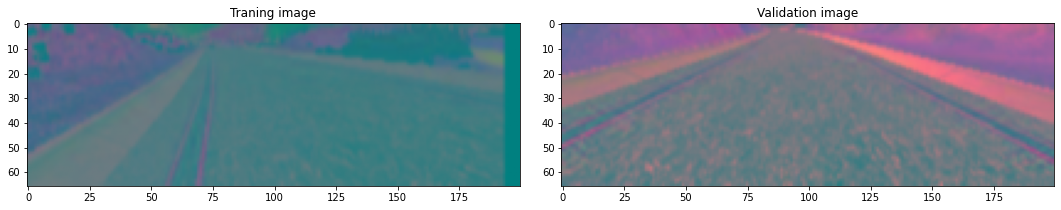

In [26]:
x_train_gen, y_train_gen = next(batch_generator(x_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(x_valid, y_valid, 1, 0))

fig, axs = plt.subplots(1,2, figsize = (15,10))
fig.tight_layout()
axs[0].imshow(x_train_gen[0])
axs[0].set_title('Traning image')
axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation image')

In [0]:
def nvidia_model():
  model = Sequential()
  model.add(Conv2D(24,(5,5), strides=(2,2), input_shape=(66,200,3),activation='elu'))
  model.add(Conv2D(36,(5,5), strides=(2,2), activation='elu'))
  model.add(Conv2D(48,(5,5), strides=(2,2), activation='elu'))
  model.add(Conv2D(64,(3,3), activation='elu'))
  model.add(Conv2D(64,(3,3), activation='elu'))
  model.add(Flatten())
  model.add(Dense(100, activation='elu'))
  #model.add(Dropout(0.5))
 
  model.add(Dense(50, activation='elu'))
  model.add(Dense(10, activation ='elu'))
  model.add(Dense(1))
 
  optimizer= Adam(lr=1e-4)
  model.compile(loss='mse', optimizer=optimizer)
  return model

In [28]:
model = nvidia_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               1

In [29]:
history = model.fit_generator(batch_generator(x_train, y_train, 100, 1), steps_per_epoch=300,epochs = 20, validation_data= batch_generator(x_valid, y_valid, 100, 0), validation_steps = 200, verbose = 1, shuffle = 1)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
300/300 [==============================] - 171s 570ms/step - loss: 0.0691 - val_loss: 0.0551
Epoch 2/20
300/300 [==============================] - 172s 573ms/step - loss: 0.0596 - val_loss: 0.0545
Epoch 3/20
300/300 [==============================] - 172s 572ms/step - loss: 0.0566 - val_loss: 0.0485
Epoch 4/20
300/300 [==============================] - 172s 575ms/step - loss: 0.0531 - val_loss: 0.0500
Epoch 5/20
300/300 [==============================] - 172s 574ms/step - loss: 0.0518 - val_loss: 0.0475
Epoch 6/20
300/300 [==============================] - 171s 571ms/step - loss: 0.0504 - val_loss: 0.0438
Epoch 7/20
300/300 [==============================] - 171s 572ms/step - loss: 0.0488 - val_loss: 0.0446
Epoch 8/20
300/300 [==============================] - 171s 571ms/step - loss: 0.0478 - val_loss: 0.0423
Epoch 9/20
300/300 [==============================] - 173s 577ms/step - loss: 0.0470 - val_l

Text(0.5, 0, 'Epoch')

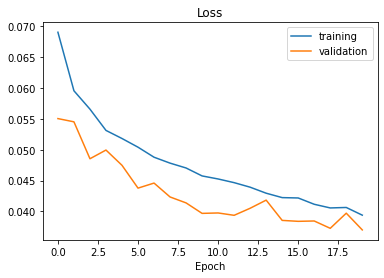

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [0]:
model.save('model.h5')

In [0]:
from google.colab import files 
files.download('model.h5')